# Structured & Time Series Data

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler

PATH = '/home/paperspace/data/rossmann/'

In [3]:
data = pd.read_feather(f'{PATH}joined')
data.shape

(844338, 93)

In [5]:
data.head().T.head(93)

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1


In [6]:
target = 'Sales'
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']
cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [7]:
train = data[data['Date'] < '2015-05-01']
test = data[data['Date'] >= '2015-05-01']
train = train.set_index('Date')
test = test.set_index('Date')

train.shape, test.shape

((759848, 92), (84490, 92))

In [8]:
train[cat_vars] = train[cat_vars].fillna(value='')
test[cat_vars] = test[cat_vars].fillna(value='')
train[cont_vars] = train[cont_vars].fillna(value=0)
test[cont_vars] = test[cont_vars].fillna(value=0)

In [9]:
encoders = {}
for v in cat_vars:
    le = LabelEncoder()
    le.fit(train[v].values)
    encoders[v] = le
    train.loc[:, v] = le.transform(train[v].values)
    test.loc[:, v] = le.transform(test[v].values)
    print('{0}: {1}'.format(v, le.classes_))

Store: [   1    2    3 ... 1113 1114 1115]
DayOfWeek: [1 2 3 4 5 6 7]
Year: [2013 2014 2015]
Month: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Day: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
StateHoliday: [False  True]
CompetitionMonthsOpen: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Promo2Weeks: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
StoreType: ['a' 'b' 'c' 'd']
Assortment: ['a' 'b' 'c']
PromoInterval: ['' 'Feb,May,Aug,Nov' 'Jan,Apr,Jul,Oct' 'Mar,Jun,Sept,Dec']
CompetitionOpenSinceYear: [1900 1961 1990 1994 1995 1998 1999 2000 2001 2002 2003 2004 2005 2006
 2007 2008 2009 2010 2011 2012 2013 2014 2015]
Promo2SinceYear: [1900 2009 2010 2011 2012 2013 2014 2015]
State: ['BE' 'BW' 'BY' 'HB,NI' 'HE' 'HH' 'NW' 'RP' 'SH' 'SN' 'ST' 'TH']
Week: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42

In [10]:
X_train = train[cat_vars + cont_vars].copy()
X_test = test[cat_vars + cont_vars].copy()
y_train = train[target].copy()
y_test = test[target].copy()

In [11]:
scaler = StandardScaler()
X_train.loc[:, cont_vars] = scaler.fit_transform(train[cont_vars].values)
X_test.loc[:, cont_vars] = scaler.transform(test[cont_vars].values)

In [12]:
for v in cat_vars:
    X_train[v] = X_train[v].astype('int').astype('category').cat.as_ordered()
    X_test[v] = X_test[v].astype('int').astype('category').cat.as_ordered()
for v in cont_vars:
    X_train[v] = X_train[v].astype('float32')
    X_test[v] = X_test[v].astype('float32')

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((759848, 38), (84490, 38), (759848,), (84490,))

In [14]:
X_train.head()

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday
Date,,,,,,,,,,,,,,,,,,,,,
2015-04-30,0,3,2,3,29,0,24,0,2,0,...,-0.742164,1.376437,-0.315052,0.393916,1.176121,0.859532,-0.504405,1.215716,1.115535,-0.489606
2015-04-30,1,3,2,3,29,0,24,25,0,0,...,-1.151942,1.818074,0.679387,0.393916,-0.194970,0.859532,-0.504405,1.215716,1.115535,-0.489606
2015-04-30,2,3,2,3,29,0,24,25,0,0,...,-0.178720,0.713981,0.679387,-0.057684,1.633151,0.859532,-0.504405,1.215716,1.115535,-0.489606
2015-04-30,3,3,2,3,29,0,24,0,2,2,...,-1.254386,0.382753,0.347908,-0.057684,0.444872,0.859532,-0.504405,1.215716,1.115535,-0.489606
2015-04-30,4,3,2,3,29,0,0,0,0,0,...,-1.510497,0.382753,0.679387,0.393916,-0.194970,0.859532,-0.504405,1.215716,1.115535,-0.489606


In [15]:
X_train.dtypes

Store                       category
DayOfWeek                   category
Year                        category
Month                       category
Day                         category
StateHoliday                category
CompetitionMonthsOpen       category
Promo2Weeks                 category
StoreType                   category
Assortment                  category
PromoInterval               category
CompetitionOpenSinceYear    category
Promo2SinceYear             category
State                       category
Week                        category
Events                      category
Promo_fw                    category
Promo_bw                    category
StateHoliday_fw             category
StateHoliday_bw             category
SchoolHoliday_fw            category
SchoolHoliday_bw            category
CompetitionDistance          float32
Max_TemperatureC             float32
Mean_TemperatureC            float32
Min_TemperatureC             float32
Max_Humidity                 float32
M

In [16]:
cat_sizes = [(c, len(X_train[c].cat.categories)) for c in cat_vars]
cat_sizes

[('Store', 1115),
 ('DayOfWeek', 7),
 ('Year', 3),
 ('Month', 12),
 ('Day', 31),
 ('StateHoliday', 2),
 ('CompetitionMonthsOpen', 25),
 ('Promo2Weeks', 26),
 ('StoreType', 4),
 ('Assortment', 3),
 ('PromoInterval', 4),
 ('CompetitionOpenSinceYear', 23),
 ('Promo2SinceYear', 8),
 ('State', 12),
 ('Week', 52),
 ('Events', 22),
 ('Promo_fw', 6),
 ('Promo_bw', 6),
 ('StateHoliday_fw', 3),
 ('StateHoliday_bw', 3),
 ('SchoolHoliday_fw', 8),
 ('SchoolHoliday_bw', 8)]

In [17]:
embedding_sizes = [(c, min(50, (c + 1) // 2)) for _, c in cat_sizes]
embedding_sizes

[(1115, 50),
 (7, 4),
 (3, 2),
 (12, 6),
 (31, 16),
 (2, 1),
 (25, 13),
 (26, 13),
 (4, 2),
 (3, 2),
 (4, 2),
 (23, 12),
 (8, 4),
 (12, 6),
 (52, 26),
 (22, 11),
 (6, 3),
 (6, 3),
 (3, 2),
 (3, 2),
 (8, 4),
 (8, 4)]

In [18]:
X_train_arrays = []
X_test_arrays = []

for i, v in enumerate(cat_vars):
    X_train_arrays.append(X_train.iloc[:, i])
    X_test_arrays.append(X_test.iloc[:, i])

X_train_arrays.append(X_train.iloc[:, len(cat_vars):])
X_test_arrays.append(X_test.iloc[:, len(cat_vars):])

len(X_train_arrays), len(X_test_arrays)

(23, 23)

In [19]:
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.models import Model
from keras.layers import Activation, BatchNormalization, Concatenate
from keras.layers import Dropout, Dense, Input, Reshape
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [22]:
def build_model(optimizer):
    inputs = []
    outputs = []
    for (c, (in_size, out_size)) in zip(cat_vars, embedding_sizes):
        i = Input(shape=(1,))
        o = Embedding(in_size, out_size, name=c)(i)
        o = Reshape(target_shape=(out_size,))(o)
        inputs.append(i)
        outputs.append(o)

    cont_input = Input(shape=(len(cont_vars),))
    inputs.append(cont_input)
    outputs.append(cont_input)

    model_output = Concatenate()(outputs)
    model_output = Dropout(0.04)(model_output)

    model_output = Dense(1000, kernel_regularizer=regularizers.l2(0.0001))(model_output)
    model_output = BatchNormalization()(model_output)
    model_output = Activation('relu')(model_output)
    model_output = Dropout(0.01)(model_output)

    model_output = Dense(500, kernel_regularizer=regularizers.l2(0.0001))(model_output)
    model_output = BatchNormalization()(model_output)
    model_output = Activation('relu')(model_output)
    model_output = Dropout(0.01)(model_output)

    model_output = Dense(100, kernel_regularizer=regularizers.l2(0.0001))(model_output)
    model_output = BatchNormalization()(model_output)
    model_output = Activation('relu')(model_output)
    model_output = Dropout(0.01)(model_output)

    model_output = Dense(1)(model_output)
    model_output = Activation('linear')(model_output)

    model = Model(inputs=inputs, outputs=model_output)

    if optimizer == 'adam': opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)
    else: opt = SGD(lr=0.01, momentum=0.9, nesterov=False)

    model.compile(loss='mean_absolute_error', optimizer=opt)

    return model

In [23]:
model = build_model(optimizer='adam')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_6 (I

In [30]:
# !rm clr.py
!wget "https://raw.githubusercontent.com/titu1994/keras-one-cycle/master/clr.py"

--2018-09-06 20:40:47--  https://raw.githubusercontent.com/titu1994/keras-one-cycle/master/clr.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.200.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.200.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22310 (22K) [text/plain]
Saving to: ‘clr.py’

clr.py              100%[===================>]  21.79K  --.-KB/s    in 0.009s  

2018-09-06 20:40:47 (2.30 MB/s) - ‘clr.py’ saved [22310/22310]



In [31]:
from clr import LRFinder, OneCycleLR

In [32]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers:
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [33]:
train_size = X_train.shape[0]
batch_size = 1024
n_epochs = 1
checkpoint = ModelCheckpoint('best_model_weights.hdf5', monitor='val_loss', save_best_only=True)
lr_finder = LRFinder(num_samples=train_size, batch_size=batch_size, minimum_lr=1e-5,
                     maximum_lr=10, lr_scale='exp', loss_smoothing_beta=0.995, verbose=False)

In [34]:
model = build_model(optimizer='adam')
reset_weights(model)
history = model.fit(x=X_train_arrays, y=y_train, batch_size=batch_size, epochs=n_epochs, verbose=1,
                    callbacks=[lr_finder], validation_data=(X_test_arrays, y_test), shuffle=False)

Train on 759848 samples, validate on 84490 samples
Epoch 1/1
759848/759848 [==============================] - 16s 21us/step - loss: 5051.5860 - val_loss: 6114.0986


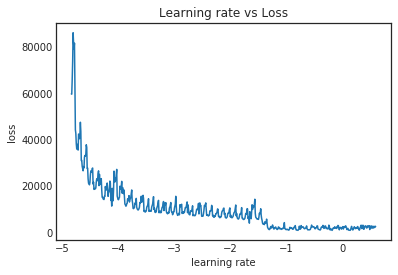

In [35]:
lr_finder.plot_schedule(clip_beginning=20)

In [38]:
n_epochs = 10
lr_manager = OneCycleLR(num_samples=train_size + batch_size, num_epochs=n_epochs, batch_size=batch_size, max_lr=0.01,
                        end_percentage=0.1, scale_percentage=None, maximum_momentum=None,
                        minimum_momentum=None, verbose=False)

In [39]:
model = build_model(optimizer='adam')
reset_weights(model)
history = model.fit(x=X_train_arrays, y=y_train, batch_size=batch_size, epochs=10, verbose=1,
                    callbacks=[checkpoint, lr_manager], validation_data=(X_test_arrays, y_test), shuffle=False)

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Train on 759848 samples, validate on 84490 samples
Epoch 1/10
759848/759848 [==============================] - 15s 20us/step - loss: 6778.3876 - val_loss: 6553.4872
Epoch 2/10
759848/759848 [==============================] - 13s 17us/step - loss: 4508.1145 - val_loss: 1608.7819
Epoch 3/10
759848/759848 [==============================] - 13s 17us/step - loss: 1437.6864 - val_loss: 1521.7318
Epoch 4/10
759848/759848 [==============================] - 13s 17us/step - loss: 1302.6098 - val_loss: 1449.4523
Epoch 5/10
759848/759848 [==============================] - 13s 17us/step - loss: 1208.5390 - val_loss: 1755.0330
Epoch 6/10
759848/759848 [==============================] - 13s 17us/step - loss: 1091.7881 - val_loss: 1527.1753
Epoch 7/10
759848/759848 [==============================] - 13s 17us/step - loss: 1034.5421 - val_loss: 1588.3431
Epoch 8/10
759848/759848 [==============================] - 13s 17us/step - loss: 999.9778 - val_loss: 1528.4780
Epoch 9/10
759848/759848 [============

In [40]:
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']
min_val_epoch = val_loss_history.index(min(val_loss_history)) + 1

print('min training loss = {0}'.format(min(loss_history)))
print('min val loss = {0}'.format(min(val_loss_history)))
print('min val epoch = {0}'.format(min_val_epoch))

min training loss = 970.3034555166071
min val loss = 1331.7580479372098
min val epoch = 10


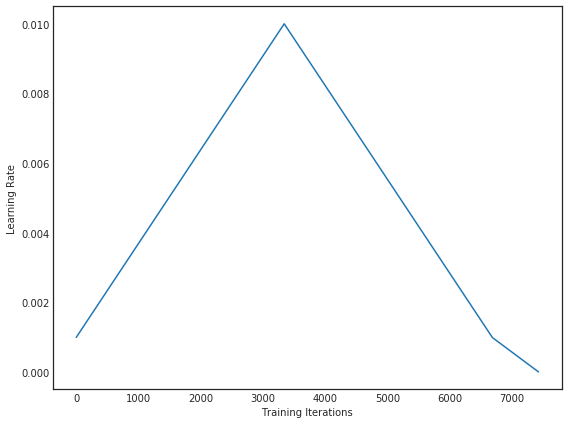

In [42]:
def plot_learning_rate(lr_manager):
    fig, ax = plt.subplots(figsize=(8, 8 * 3 / 4))
    ax.set_xlabel('Training Iterations')
    ax.set_ylabel('Learning Rate')
    ax.plot(lr_manager.history['lr'])
    fig.tight_layout()

plot_learning_rate(lr_manager)

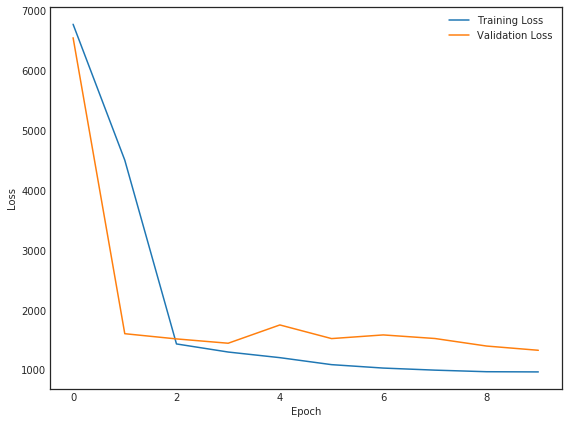

In [43]:
def plot_loss_history(history, n_epochs):
    fig, ax = plt.subplots(figsize=(8, 8 * 3 / 4))
    ax.plot(list(range(n_epochs)), history.history['loss'], label='Training Loss')
    ax.plot(list(range(n_epochs)), history.history['val_loss'], label='Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend(loc='upper right')
    fig.tight_layout()

plot_loss_history(history, n_epochs)

In [46]:
def plot_embedding(model, encoders, category):
    embedding_layer = model.get_layer(category)
    weights = embedding_layer.get_weights()[0]
    pca = PCA(n_components=2)
    weights = pca.fit_transform(weights)
    weights_t = weights.T
    fig, ax = plt.subplots(figsize=(8, 8 * 3 / 4))
    ax.scatter(weights_t[0], weights_t[1])
    for i, day in enumerate(encoders[category].classes_):
        ax.annotate(day, (weights_t[0, i], weights_t[1, i]))
        fig.tight_layout()

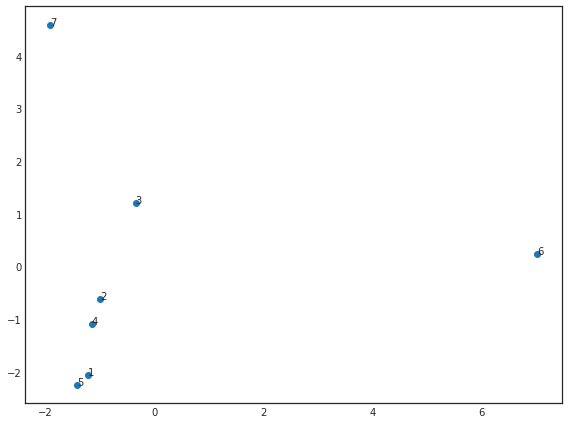

In [47]:
plot_embedding(model, encoders, 'DayOfWeek')

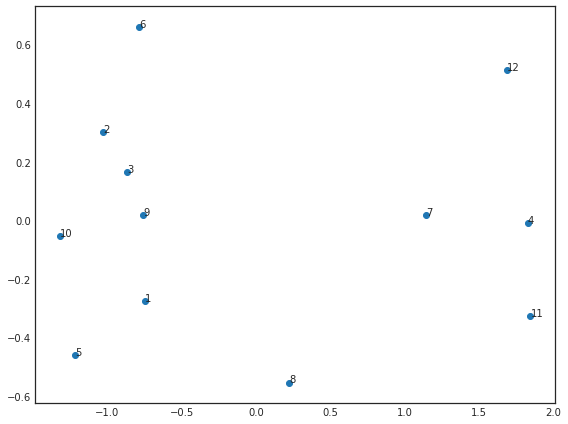

In [48]:
plot_embedding(model, encoders, 'Month')

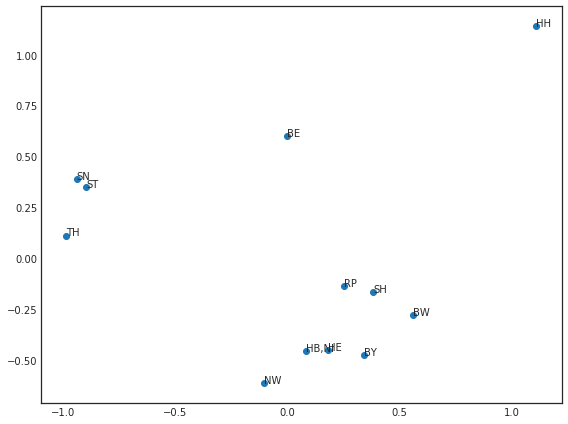

In [49]:
plot_embedding(model, encoders, 'State')